Le code est ecrit a l'aide du chatgpt, stack overflow et geek for geeks

In [1]:
import os
from skimage import io
from skimage.transform import resize
import numpy as np
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor
import cv2
import matplotlib.pyplot as plt
import mahotas 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from skimage.feature import graycomatrix, graycoprops



<h2>Defining descriptors

In [2]:
def extract_pixel_intensity(image):
    image_resized = resize(image, (28, 28), anti_aliasing=True)
    pixel_intensity = image_resized.mean(axis=(0, 1))  
    return pixel_intensity


In [4]:
def extract_sift(image):
    image_resized = resize(image, (28, 28), anti_aliasing=True)
    
    if len(image_resized.shape) == 2:  
        image_gray = (image_resized * 255).astype(np.uint8)
    elif len(image_resized.shape) == 3:  
        image_gray = cv2.cvtColor((image_resized * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Unexpected image shape: {}".format(image_resized.shape))
    
    sift = cv2.SIFT_create()
    
    kp, des = sift.detectAndCompute(image_gray, None)
    
    if des is None:
        return np.zeros(128)
    
    return des.flatten()[:128]

In [6]:

def extract_hog(image):
    image_resized = resize(image, (28, 28), anti_aliasing=True)
    
    if len(image_resized.shape) == 2:
        image_gray = (image_resized * 255).astype(np.uint8)
    elif len(image_resized.shape) == 3: 
        image_gray = cv2.cvtColor((image_resized * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Unexpected image shape: {}".format(image_resized.shape))
    
    # Extract HOG features
    hog_features, _ = hog(
        image_gray, 
        pixels_per_cell=(8, 8), 
        cells_per_block=(2, 2), 
        visualize=True
    )
    
    return hog_features


In [8]:

def extract_lbp(image):
    image_resized = resize(image, (28, 28), anti_aliasing=True)
    
    if len(image_resized.shape) == 2: 
        image_gray = (image_resized * 255).astype(np.uint8)
    elif len(image_resized.shape) == 3:
        image_gray = cv2.cvtColor((image_resized * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Unexpected image shape: {}".format(image_resized.shape))
    
    lbp = local_binary_pattern(image_gray, P=8, R=1, method='uniform')
    
    lbp_hist = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))[0]
    
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    
    return lbp_hist


In [10]:

def extract_haralick(image):
    image_resized = resize(image, (28, 28), anti_aliasing=True)
    
    if len(image_resized.shape) == 2:  
        image_gray = (image_resized * 255).astype(np.uint8)
    elif len(image_resized.shape) == 3:  
        image_gray = cv2.cvtColor((image_resized * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Unexpected image shape: {}".format(image_resized.shape))
    
    haralick_features = mahotas.features.haralick(image_gray).mean(axis=0)
    
    contrast, homogeneity = haralick_features[1], haralick_features[8]
    
    return np.array([contrast, homogeneity])


In [12]:
def extract_gabor(image):
    image_resized = resize(image, (28, 28), anti_aliasing=True)
    
    if len(image_resized.shape) == 2:  
        image_gray = (image_resized * 255).astype(np.uint8)
    elif len(image_resized.shape) == 3:  
        image_gray = cv2.cvtColor((image_resized * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Unexpected image shape: {}".format(image_resized.shape))
    
    gabor_features = []
    for frequency in (0.1, 0.3, 0.5, 0.7, 1.0):  
        real, _ = gabor(image_gray, frequency=frequency)
        gabor_features.append(real.mean())
    
    return np.array(gabor_features)


In [14]:
from skimage.morphology import skeletonize

def skeleton_descriptor(image):
    image_resized = resize(image, (28, 28), anti_aliasing=True)
    
    if len(image_resized.shape) == 2: 
        image_gray = (image_resized * 255).astype(np.uint8)
    elif len(image_resized.shape) == 3:  
        image_gray = cv2.cvtColor((image_resized * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Unexpected image shape: {}".format(image_resized.shape))
    
    
    skeleton = skeletonize(image_gray > 128)
    
    skeleton_fraction = np.sum(skeleton) / skeleton.size
    
    return np.array([skeleton_fraction])


In [16]:
from skimage.feature import graycomatrix, graycoprops

def glcm_descriptor(image):
    image_resized = resize(image, (28, 28), anti_aliasing=True)
    
    if len(image_resized.shape) == 2:  
        image_gray = (image_resized * 255).astype(np.uint8)
    elif len(image_resized.shape) == 3:  
        image_gray = cv2.cvtColor((image_resized * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Unexpected image shape: {}".format(image_resized.shape))
    
    glcm = graycomatrix(image_gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    
    return np.array([contrast, homogeneity])


In [18]:
def extract_first_order_statistics(image):
    image_resized = resize(image, (28, 28), anti_aliasing=True)
    
    if len(image_resized.shape) == 2:  
        image_gray = (image_resized * 255).astype(np.uint8)
    elif len(image_resized.shape) == 3:  
        image_gray = cv2.cvtColor((image_resized * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Unexpected image shape: {}".format(image_resized.shape))
    
    mean_intensity = np.mean(image_gray)
    std_intensity = np.std(image_gray)
    
    return np.array([mean_intensity, std_intensity])


In [20]:
def extract_projection(image):
    image_resized = resize(image, (28, 28), anti_aliasing=True)
    
    if len(image_resized.shape) == 2: 
        image_gray = (image_resized * 255).astype(np.uint8)
    elif len(image_resized.shape) == 3:  
        image_gray = cv2.cvtColor((image_resized * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Unexpected image shape: {}".format(image_resized.shape))
    
    horizontal_projection = np.sum(image_gray, axis=1)  # Sum over rows
    vertical_projection = np.sum(image_gray, axis=0)    # Sum over columns
    
    horizontal_projection = horizontal_projection / np.sum(horizontal_projection)
    vertical_projection = vertical_projection / np.sum(vertical_projection)
    
    return np.concatenate([horizontal_projection, vertical_projection])


<h3>Distance matrix dependinng on the descriptor

In [21]:
# def compute_distance_matrix(images, descriptor_function):
#     features = [descriptor_function(image) for image in images]  
#     distance_matrix = pairwise_distances(features)  
#     return distance_matrix

In [23]:
import torch
import numpy as np

def compute_distance_matrix(images, descriptor_function, feature_size=128):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    features = []
    for image in images:
        try:
            feature = descriptor_function(image)

            if isinstance(feature, np.float64) or np.isscalar(feature):
                feature = [feature]

            feature = np.array(feature)

            if feature.size < feature_size:
                feature = np.pad(feature, (0, feature_size - feature.size), mode='constant')
            elif feature.size > feature_size:
                feature = feature[:feature_size]

            features.append(feature)
        except Exception as e:
            print(f"Error processing image: {e}")
            features.append([0] * feature_size)

    features_tensor = torch.tensor(features, dtype=torch.float32, device=device)

    distance_matrix = torch.cdist(features_tensor, features_tensor, p=2)
    return distance_matrix


In [28]:
def display_distance_matrix(distance_matrix, title):
    if isinstance(distance_matrix, torch.Tensor):
        distance_matrix = distance_matrix.cpu().numpy()
    plt.imshow(distance_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.show()


<h3>Puting the images in a list fpr readibility 

In [30]:
food_directory = 'archive/training/food'
non_food_directory = 'archive/training/non_food'

food_image_paths = [os.path.join(food_directory, filename) for filename in os.listdir(food_directory) if filename.endswith('.png') or filename.endswith('.jpg')]
food_images = [io.imread(image_path) for image_path in food_image_paths]

non_food_image_paths = [os.path.join(non_food_directory, filename) for filename in os.listdir(non_food_directory) if filename.endswith('.png') or filename.endswith('.jpg')]
non_food_images = [io.imread(image_path) for image_path in non_food_image_paths]

image_paths = food_image_paths + non_food_image_paths
images = food_images + non_food_images


<h2>Calculating the distance matrix for each descriptor

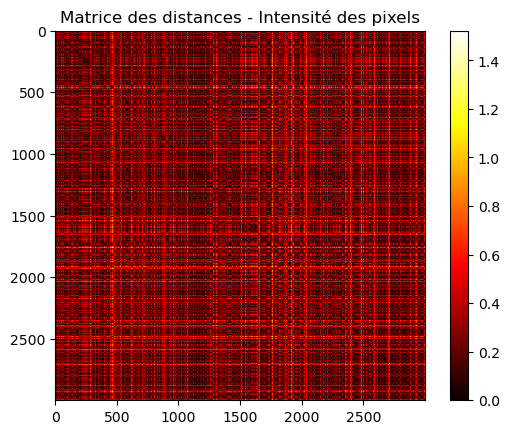

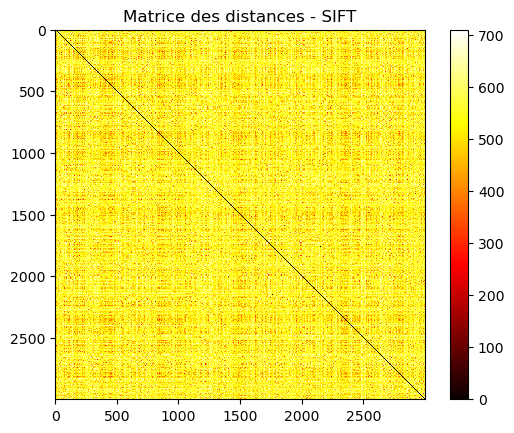

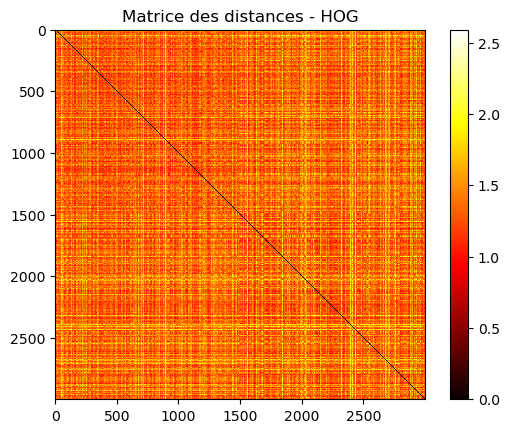

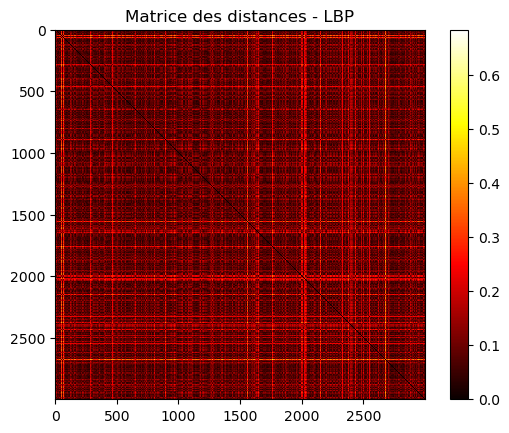

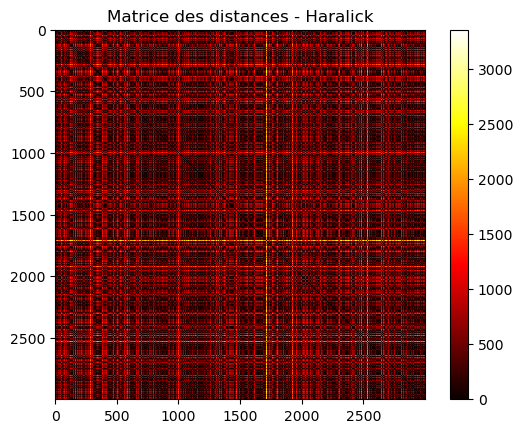

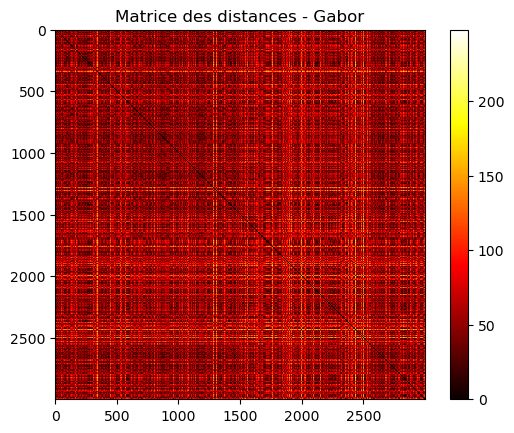

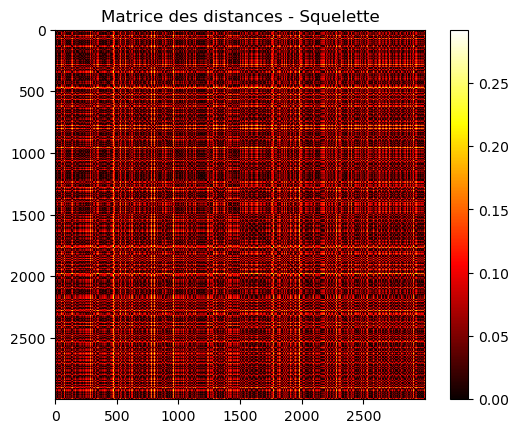

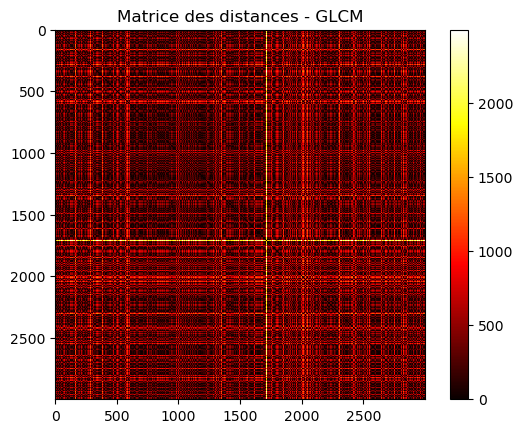

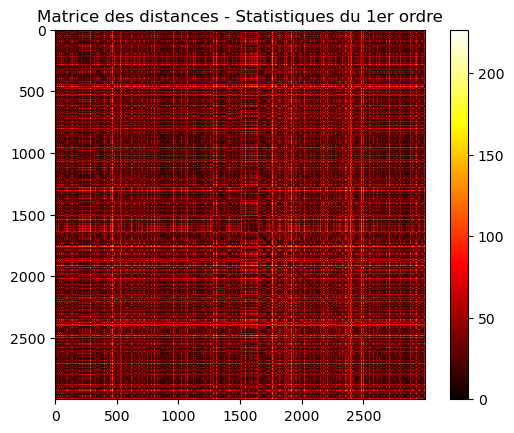

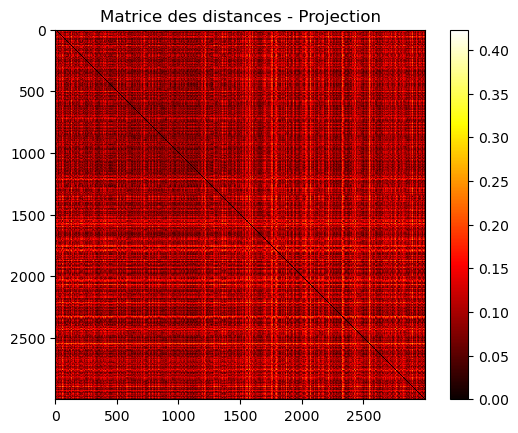

In [31]:
for descriptor_function, name in zip([extract_pixel_intensity, extract_sift, extract_hog, extract_lbp, extract_haralick, extract_gabor,skeleton_descriptor,glcm_descriptor,extract_first_order_statistics,extract_projection],
                                      ['Intensité des pixels', 'SIFT', 'HOG', 'LBP', 'Haralick', 'Gabor','Squelette','GLCM','Statistiques du 1er ordre','Projection']):
    distance_matrix = compute_distance_matrix(images, descriptor_function)
    display_distance_matrix(distance_matrix, f"Matrice des distances - {name}")


<h2>We try with merging these descriptors

In [32]:
from sklearn.preprocessing import MinMaxScaler

# Fonction d'extraction de toutes les caractéristiques
def extract_features(image):
    pixel_intensity = extract_pixel_intensity(image)  
    lbp_hist = extract_lbp(image)  
    haralick_features = extract_haralick(image) 
    gabor_features = extract_gabor(image)  
    skeleton_features = skeleton_descriptor(image) 
    glcm_features = glcm_descriptor(image) 
    first_order_features = extract_first_order_statistics(image)  
    projecions = extract_projection(image)
    features = np.hstack([pixel_intensity, lbp_hist, haralick_features, gabor_features, skeleton_features, glcm_features, first_order_features, projecions])
    # scaler = MinMaxScaler()
    # features_normalized = scaler.fit_transform(features.reshape(-1, 1)).flatten()
    return features


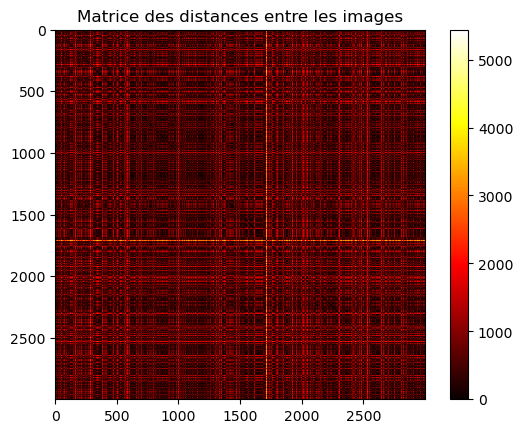

In [33]:
distance_matrix = compute_distance_matrix(images, extract_features)

display_distance_matrix(distance_matrix, "Matrice des distances entre les images")

In [34]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
import numpy as np
import cv2

def extract_resnet50_features(img):
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load a pretrained ResNet-50 model
    model = resnet50(pretrained=True)
    model = model.eval()  # Set the model to evaluation mode
    model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the classification head
    model = model.to(device)  # Move the model to the GPU/CPU

    # Define preprocessing transforms
    preprocess = transforms.Compose([
        transforms.ToPILImage(),  # Convert NumPy array to PIL image
        transforms.Resize((224, 224)),  # Resize image to 224x224
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    # Preprocess the image
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    img_tensor = img_tensor.to(device)  # Move the tensor to the GPU/CPU

    # Extract features
    with torch.no_grad():
        features = model(img_tensor)

    # Flatten the features into a 1D array
    feat = features.view(-1).cpu().numpy()  # Move back to CPU before converting to NumPy
    return feat


/home/benk/anaconda3/envs/ML/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/benk/anaconda3/envs/ML/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]


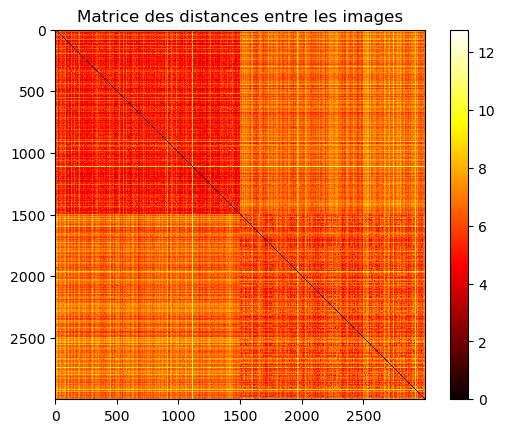

In [35]:
distance_matrix = compute_distance_matrix(images, extract_resnet50_features)

display_distance_matrix(distance_matrix, "Matrice des distances entre les images")


In [37]:
from torchvision.models import densenet121

def extract_densenet121_features(img):
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load a pretrained DenseNet-121 model
    model = densenet121(pretrained=True)
    model = model.eval()  # Set the model to evaluation mode
    model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the classification head
    model = model.to(device)  # Move the model to the GPU/CPU

    # Define preprocessing transforms
    preprocess = transforms.Compose([
        transforms.ToPILImage(),  # Convert NumPy array to PIL image
        transforms.Resize((224, 224)),  # Resize image to 224x224
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    # Preprocess the image
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    img_tensor = img_tensor.to(device)  # Move the tensor to the GPU/CPU

    # Extract features
    with torch.no_grad():
        features = model(img_tensor)

    # Flatten the features into a 1D array
    feat = features.view(-1).cpu().numpy()  # Move back to CPU before converting to NumPy
    return feat

/home/benk/anaconda3/envs/ML/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]


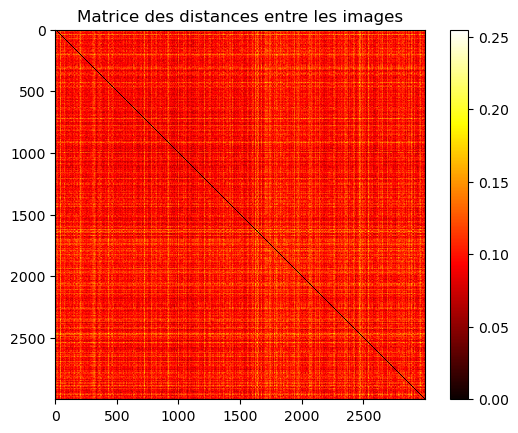

In [38]:
distance_matrix = compute_distance_matrix(images, extract_densenet121_features)

display_distance_matrix(distance_matrix, "Matrice des distances entre les images")
